In [1]:
import io
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
conn = sqlite3.connect('./conn_despesas_publicas_tp1.db')
cursor = conn.cursor()

In [3]:
f = io.open('./despesas_publicas_tp1.sql', 'r', encoding='latin-1')
sql = f.read()
try:
    cursor.executescript(sql)
except:
    pass

In [4]:
#minhas consultas da 4.1
#2018054630
#(0+1) = 1
#(5+1) = 6
#(4+1) = 5
#(6+1) = 7
#(3+1) = 4
#(0+1) = 1, mas ja tem 1, entao = 2

# Questão 4.1
-----
### 1) Liste todos os códigos e nomes de subfunções da função que possui o maior número de subfunções

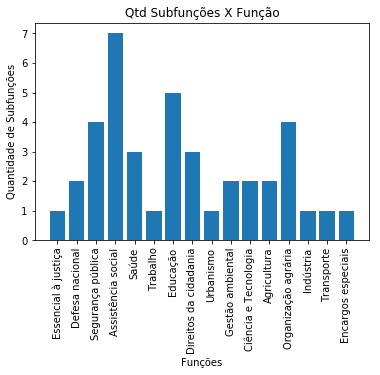

SELECT SF.COD_SUBFUNCAO, SF.NOME_SUBFUNCAO          FROM (SELECT COD_FUNCAO, MAX(QTDE)                                    FROM (SELECT COD_FUNCAO, COUNT(*) AS QTDE                                     FROM (SELECT DISTINCT COD_FUNCAO, COD_SUBFUNCAO                                           FROM DETALHAMENTO_FUNCAO)                                    GROUP BY COD_FUNCAO)) T1         NATURAL JOIN DETALHAMENTO_FUNCAO DF         NATURAL JOIN SUBFUNCAO SF;


In [5]:
quantidade_subfuncoes_por_funcao = "SELECT COD_FUNCAO, COUNT(*) AS QTDE \
                                    FROM (SELECT DISTINCT COD_FUNCAO, COD_SUBFUNCAO \
                                          FROM DETALHAMENTO_FUNCAO)"

nome_funcao_por_subfuncoes = "SELECT * \
                              FROM FUNCAO FU \
                              NATURAL JOIN ("+quantidade_subfuncoes_por_funcao+" GROUP BY COD_FUNCAO);"



df = pd.read_sql_query(nome_funcao_por_subfuncoes, conn)
#display(df)
plt.title('Qtd Subfunções X Função')
plt.bar(df['NOME_FUNCAO'].tolist(), df['QTDE'].tolist())
plt.xlabel("Funções")
plt.xticks(rotation=90)
plt.ylabel("Quantidade de Subfunções")
plt.show()

funcao_com_maximo_de_subfuncoes = "SELECT COD_FUNCAO, MAX(QTDE) \
                                   FROM ("+quantidade_subfuncoes_por_funcao+" \
                                   GROUP BY COD_FUNCAO)"

query = "SELECT SF.COD_SUBFUNCAO, SF.NOME_SUBFUNCAO \
         FROM (" + funcao_com_maximo_de_subfuncoes + ") T1 \
        NATURAL JOIN DETALHAMENTO_FUNCAO DF \
        NATURAL JOIN SUBFUNCAO SF;"

print(query.replace('\n', ''))
df = pd.read_sql_query(query, conn)

### 2) Liste o valor total de despesas públicas por função(nome) e subfunção (nome), apenas nos casos em que esse valor total excedeu 200 mil reais

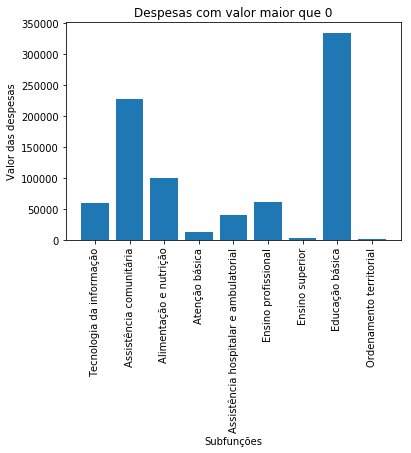

NOME_FUNCAO           NOME_SUBFUNCAO      VALOR
0  Assistência social  Assistência comunitária  227883.77
1            Educação          Educação básica  334262.06

In [6]:
selecao_de_dados = "SELECT F.NOME_FUNCAO, SF.NOME_SUBFUNCAO, VALOR \
                   FROM FUNCAO F \
                   NATURAL JOIN DETALHAMENTO_FUNCAO DF \
                   NATURAL JOIN SUBFUNCAO SF "

despesas_por_detalhamento = "SELECT COD_DETALHAMENTO, SUM(VALOR_DESPESA) AS VALOR \
                           FROM DESPESA_PUBLICA GROUP BY COD_DETALHAMENTO"

df = pd.read_sql_query(selecao_de_dados+" NATURAL JOIN ("+despesas_por_detalhamento+" HAVING VALOR>0) DP;", conn)
plt.bar(df['NOME_SUBFUNCAO'].tolist(), df['VALOR'].tolist())
plt.title('Despesas com valor maior que 0')
plt.xlabel("Subfunções")
plt.xticks(rotation=90)
plt.ylabel("Valor das despesas")
plt.show()

despesas_por_detalhamento_2e6 = despesas_por_detalhamento + " HAVING VALOR > 200000"

query = selecao_de_dados + "NATURAL JOIN ("+despesas_por_detalhamento_2e6+") DP;"
df = pd.read_sql_query(query, conn)
display(df)

### 4) Liste o mês e ano, modalidade, programa de governo e valor de todas as despesas do órgão Ministério da Fazenda no primeiro semestre de 2018.

In [7]:
df = pd.read_sql_query("SELECT DP.MES_DESPESA, DP.ANO_DESPESA, DP.MODALIDADE_DESPESA, PG.*, DP.VALOR_DESPESA "+
                       "FROM ORGAO ORG NATURAL JOIN DESPESA_PUBLICA DP NATURAL JOIN PROGRAMA_GOVERNO PG "+
                       "WHERE ORG.NOME_ORGAO LIKE 'Ministério da Fazenda' "+
                       "ORDER BY DP.ANO_DESPESA, DP.MES_DESPESA;", conn)
display(df)

MES_DESPESA  ANO_DESPESA       MODALIDADE_DESPESA  COD_PROGRAMA_GOVERNO  \
0             1         2018  Reserva de Contingência                    24   
1             2         2018  Reserva de Contingência                    24   
2             3         2018  Reserva de Contingência                    24   
3             4         2018  Reserva de Contingência                    16   
4             4         2018  Reserva de Contingência                    24   
5             5         2018  Reserva de Contingência                    24   
6             6         2018  Reserva de Contingência                    24   
7             7         2018  Reserva de Contingência                    24   
8             8         2018  Reserva de Contingência                    24   
9             9         2018  Reserva de Contingência                    16   
10           10         2018  Reserva de Contingência                    24   
11           11         2018  Reserva de Contingência                    24   
12           12         2018  Reserva de Contingência                    24   

   NOME_PROGRAMA_GOVERNO  VALOR_DESPESA  
0     BRASIL SEM MISERIA              0  
1     BRASIL SEM MISERIA              0  
2     BRASIL SEM MISERIA              0  
3   GESTAO AEROPORTUARIA              0  
4     BRASIL SEM MISERIA              0  
5     BRASIL SEM MISERIA              0  
6     BRASIL SEM MISERIA              0  
7     BRASIL SEM MISERIA              0  
8     BRASIL SEM MISERIA              0  
9   GESTAO AEROPORTUARIA              0  
10    BRASIL SEM MISERIA              0  
11    BRASIL SEM MISERIA              0  
12    BRASIL SEM MISERIA              0

### 5) Liste o código e nome dos programas de governo que possuíram os 3 maiores valores de despesas totais na função de educação durante o ano de 2018.

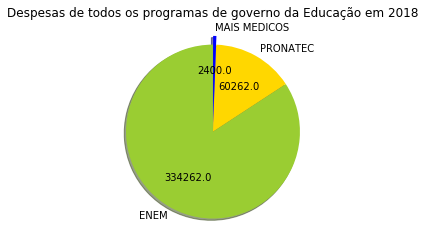

COD_PROGRAMA_GOVERNO NOME_PROGRAMA_GOVERNO
0                    11                  ENEM
1                    14              PRONATEC
2                    35          MAIS MEDICOS

In [8]:
despesas_educacao_2018 = "FROM DESPESA_PUBLICA DP1 \
                          NATURAL JOIN DETALHAMENTO_FUNCAO DF \
                          NATURAL JOIN FUNCAO FU \
                          WHERE FU.NOME_FUNCAO LIKE 'Educação' \
                          AND DP1.ANO_DESPESA = 2018 \
                          GROUP BY DP1.COD_PROGRAMA_GOVERNO \
                          HAVING SUM(DP1.VALOR_DESPESA) \
                          ORDER BY SUM(DP1.VALOR_DESPESA) DESC"

graph_query = "SELECT PG.NOME_PROGRAMA_GOVERNO, DF.VALOR \
               FROM PROGRAMA_GOVERNO PG \
               NATURAL JOIN (SELECT DP1.COD_PROGRAMA_GOVERNO, SUM(DP1.VALOR_DESPESA) AS VALOR \
                             " +despesas_educacao_2018 +") DF"

df = pd.read_sql_query(graph_query, conn)
#display(df)
sizes = np.array(df['VALOR'].tolist())

def absolute_value(val):
    a  = np.round(val/100.*sizes.sum(), 0)
    return a

plt.title('Despesas de todos os programas de governo da Educação em 2018')
colors = ['yellowgreen', 'gold', 'blue']
explode = (0, 0, 0.1)
plt.pie(sizes, explode=explode, labels=df['NOME_PROGRAMA_GOVERNO'], colors=colors, autopct=absolute_value,shadow=True, startangle=90)
plt.show()

query = "SELECT PG.COD_PROGRAMA_GOVERNO, PG.NOME_PROGRAMA_GOVERNO \
         FROM PROGRAMA_GOVERNO PG \
         WHERE PG.COD_PROGRAMA_GOVERNO IN \
             (SELECT DP1.COD_PROGRAMA_GOVERNO "+ despesas_educacao_2018 +" LIMIT 3);"

df = pd.read_sql_query(query, conn)
display(df)

### 6) Liste todos os nomes de funçõs e subfunções das despesas públicas do terceiro trimestre de 2018 e seus respectivos valores totais, apenas para o programa MAIS MEDICOS

In [9]:
despesas_mais_medicos_2018 = "SELECT COD_DETALHAMENTO \
                              FROM DESPESA_PUBLICA DP \
                              NATURAL JOIN PROGRAMA_GOVERNO PG \
                              WHERE DP.ANO_DESPESA = 2018 \
                              AND DP.MES_DESPESA > 9 \
                              AND PG.NOME_PROGRAMA_GOVERNO LIKE 'MAIS MEDICOS'"

funcoes_subfuncoes = "SELECT DISTINCT FU.NOME_FUNCAO, SF.NOME_SUBFUNCAO \
                      FROM FUNCAO FU \
                      NATURAL JOIN SUBFUNCAO SF \
                      NATURAL JOIN DETALHAMENTO_FUNCAO DF \
                      WHERE DF.COD_DETALHAMENTO IN (" + despesas_mais_medicos_2018 + "); "

df = pd.read_sql_query(funcoes_subfuncoes, conn)
display(df)

NOME_FUNCAO                         NOME_SUBFUNCAO
0  Defesa nacional                    Administração geral
1            Saúde           Formação de recursos humanos
2            Saúde                         Atenção básica
3         Educação  Assistência hospitalar e ambulatorial
4         Educação                        Ensino superior

### 7) Liste os órgãos governamentais e a quantidade de programas de governo distintos envolvidos nas despesas públicas desses órgãos. Nesta consulta, desconsidere valores de despesa negativos ou iguais a zero no período

In [10]:
programas_governo_distintos_por_despesas = "SELECT COD_ORGAO, COUNT(*) AS QTD \
                                      FROM (SELECT DISTINCT COD_DESPESA, COD_PROGRAMA_GOVERNO, COD_ORGAO \
                                            FROM DESPESA_PUBLICA \
                                            WHERE VALOR_DESPESA > 0) \
                                      GROUP BY COD_ORGAO"


orgaos_governamentais = "SELECT ORG.NOME_ORGAO, ORG.COD_ORGAO, IFNULL(QTD,0) AS QTD \
                         FROM ORGAO ORG \
                         NATURAL JOIN (" + programas_governo_distintos_por_despesas +");"

df = pd.read_sql_query(orgaos_governamentais, conn)
display(df)

NOME_ORGAO  COD_ORGAO  QTD
0  Ministério da Agricultura, Pecuária e Abastec      22000    4
1                         Ministério da Educação      26000   10
2                            Ministério da Saúde      36000    3
3                           Ministério da Defesa      52000    2
4           Ministério do Desenvolvimento Social      55000    2

# Questão 4.2
-----
### 12) $$ \pi_{NOME FUNCAO, NOME SUBFUNCAO}(FUNCAO \Join DETALHAMENTO FUNCAO \Join SUBFUNCAO)$$

In [11]:
#questao 12

query = "SELECT DISTINCT FU.NOME_FUNCAO, SF.NOME_SUBFUNCAO \
         FROM FUNCAO FU NATURAL JOIN DETALHAMENTO_FUNCAO NATURAL JOIN SUBFUNCAO SF;"

df = pd.read_sql_query(query, conn)
display(df)

NOME_FUNCAO                                    NOME_SUBFUNCAO
0     Essencial à justiça                                Comunicação social
1         Defesa nacional                               Administração geral
2         Defesa nacional                                  Defesa terrestre
3       Segurança pública                               Administração geral
4       Segurança pública                                      Policiamento
5       Segurança pública                                      Defesa civil
6       Segurança pública                         Informação e inteligência
7      Assistência social                       Normatização e fiscalização
8      Assistência social                          Tecnologia da informação
9      Assistência social                                Comunicação social
10     Assistência social                           Assistência comunitária
11     Assistência social                            Alimentação e nutrição
12     Assistência social                                 Educação infantil
13     Assistência social                           Saneamento básico rural
14                  Saúde                      Formação de recursos humanos
15                  Saúde                                    Atenção básica
16                  Saúde             Assistência hospitalar e ambulatorial
17               Trabalho                               Fomento ao trabalho
18               Educação             Assistência hospitalar e ambulatorial
19               Educação                               Ensino profissional
20               Educação                                   Ensino superior
21               Educação                                   Educação básica
22               Educação             Transferências para a educação básica
23  Direitos da cidadania            Assistência ao portador de deficiência
24  Direitos da cidadania                    Custódia e reintegração social
25  Direitos da cidadania         Direitos individuais, coletivos e difusos
26              Urbanismo                           Assistência comunitária
27       Gestão ambiental               Preservação e conservação ambiental
28       Gestão ambiental                                 Recursos hídricos
29   Ciência e Tecnologia                        Desenvolvimento científico
30   Ciência e Tecnologia          Desenvolvimento tecnológico e engenharia
31            Agricultura  Difusão do conhecimento científico e tecnológico
32            Agricultura                 Promoção da produção agropecuária
33    Organização agrária                       Normatização e fiscalização
34    Organização agrária                           Ordenamento territorial
35    Organização agrária                                    Extensão rural
36    Organização agrária                                   Reforma agrária
37              Indústria                                Promoção comercial
38             Transporte                               Administração geral
39     Encargos especiais                         Outros encargos especiais

### 13) $$ \pi_{MODALIDADE DESPESA, VALOR DESPESA, NOME PROGRAMA GOVERNO}(PROGRAMA\_GOVERNO \Join \sigma_{MODALIDADE\_DESPESA=‘Reserva de Contingência’ }(DESPESA PUBLICA))$$

In [12]:
#questao 13
query = "SELECT DISTINCT DP.MODALIDADE_DESPESA, DP.VALOR_DESPESA, PG.NOME_PROGRAMA_GOVERNO\
         FROM PROGRAMA_GOVERNO PG \
         NATURAL JOIN (SELECT * FROM DESPESA_PUBLICA WHERE MODALIDADE_DESPESA LIKE 'Reserva de Contingência') DP;"

df = pd.read_sql_query(query, conn)
display(df)

MODALIDADE_DESPESA  VALOR_DESPESA  \
0   Reserva de Contingência           0.00   
1   Reserva de Contingência           0.00   
2   Reserva de Contingência           0.00   
3   Reserva de Contingência        8215.70   
4   Reserva de Contingência           3.42   
5   Reserva de Contingência       81120.13   
6   Reserva de Contingência           0.00   
7   Reserva de Contingência        1497.26   
8   Reserva de Contingência           0.00   
9   Reserva de Contingência           0.00   
10  Reserva de Contingência           0.00   
11  Reserva de Contingência           0.00   
12  Reserva de Contingência           0.00   
13  Reserva de Contingência           0.00   
14  Reserva de Contingência           0.00   
15  Reserva de Contingência        1210.00   
16  Reserva de Contingência           0.00   
17  Reserva de Contingência           0.00   
18  Reserva de Contingência           0.00   
19  Reserva de Contingência         135.36   
20  Reserva de Contingência           0.00   
21  Reserva de Contingência        2000.00   
22  Reserva de Contingência           0.00   
23  Reserva de Contingência       18178.00   
24  Reserva de Contingência       28073.08   
25  Reserva de Contingência         385.38   
26  Reserva de Contingência        5900.00   
27  Reserva de Contingência           0.00   
28  Reserva de Contingência           0.00   
29  Reserva de Contingência           0.00   
30  Reserva de Contingência        2400.00   
31  Reserva de Contingência           0.00   
32  Reserva de Contingência           0.00   
33  Reserva de Contingência           0.00   
34  Reserva de Contingência           0.00   
35  Reserva de Contingência           0.00   
36  Reserva de Contingência       38971.19   
37  Reserva de Contingência       11000.00   
38  Reserva de Contingência        1000.00   
39  Reserva de Contingência      334126.70   
40  Reserva de Contingência       19250.00   
41  Reserva de Contingência       58918.28   

                                NOME_PROGRAMA_GOVERNO  
0                                  BRASIL SEM MISERIA  
1                               VIOLENCIA NO TRANSITO  
2                            TERRITORIOS DA CIDADANIA  
3                                  BRASIL SEM MISERIA  
4                                  BRASIL SEM MISERIA  
5                                  BRASIL SEM MISERIA  
6                             REGULARIZACAO FUNDIARIA  
7                             REGULARIZACAO FUNDIARIA  
8                                SEGURO RURAL PRIVADO  
9                                    VIVER SEM LIMITE  
10                             CIENCIA SEM FRONTEIRAS  
11                               GESTAO AEROPORTUARIA  
12                                 DESASTRES NATURAIS  
13                                SATELITE (TELEBRAS)  
14                                     MELHOR EM CASA  
15                                       REDE CEGONHA  
16                                       REDE CEGONHA  
17                                 CONTROLE DO CANCER  
18                                               ENEM  
19                                               ENEM  
20                                       PROVA BRASIL  
21                                           PRONATEC  
22                                           PRONATEC  
23                                           PRONATEC  
24                                           PRONATEC  
25                                           PRONATEC  
26                                           PRONATEC  
27                                   CADEIAS PUBLICAS  
28                           CRACK, E POSSIVEL VENCER  
29                                       MAIS MEDICOS  
30                                       MAIS MEDICOS  
31                             CRIMINALIDADE VIOLENTA  
32                                         OLIMPIADAS  
33                                             SINESP  
34                                            ENAFRON  
35  UPA (INVES

### 14) $$ \pi_{VALOR\_DESPESA, NOME\_ORGAO} (DESPESA\_PUBLICA\Join\sigma_{NOME\_ORGAO=‘Ministério da Fazenda’} (ORGAO))$$

In [13]:
query = "SELECT DISTINCT DP.VALOR_DESPESA, ORG.NOME_ORGAO \
         FROM DESPESA_PUBLICA DP \
         NATURAL JOIN (SELECT * FROM ORGAO WHERE NOME_ORGAO LIKE 'Ministério da Fazenda') ORG;"

df = pd.read_sql_query(query, conn)
display(df)

VALOR_DESPESA             NOME_ORGAO
0              0  Ministério da Fazenda

### 15) $$\pi_{NOME\_PROGRAMA\_GOVERNO, VALOR\_DESPESA} (DESPESA\_PUBLICA\Join\sigma_{NOME\_ORGAO=’Ministério da Saúde’}(ORGAO)\Join PROGRAMA\_GOVERNO) $$

In [14]:
query = "SELECT DISTINCT PG.NOME_PROGRAMA_GOVERNO, DP.VALOR_DESPESA \
         FROM DESPESA_PUBLICA DP \
         NATURAL JOIN (SELECT * FROM ORGAO WHERE NOME_ORGAO LIKE 'Ministério da Saúde') ORG \
         NATURAL JOIN PROGRAMA_GOVERNO PG;"
df = pd.read_sql_query(query, conn)
display(df)

NOME_PROGRAMA_GOVERNO  VALOR_DESPESA
0                                    VIVER SEM LIMITE           0.00
1                                      SOS EMERGENCIA           0.00
2                                      MELHOR EM CASA           0.00
3                                                 UBS           0.00
4   UPA (INVESTIMENTO, CUSTEIO E COMPLEXO DE REGUL...           0.00
5                                        REDE CEGONHA           0.00
6                                  CONTROLE DO CANCER           0.00
7                                  CONTROLE DO CANCER       38971.19
8                            CRACK, E POSSIVEL VENCER           0.00
9                                  BRASIL SEM MISERIA           0.00
10  PROGRAMA NACIONAL DE MELHORIA DE ACESSO E QUAL...           0.00
11                                       MAIS MEDICOS           0.00
12                                       MAIS MEDICOS       11000.00
13                                       MAIS MEDICOS        1000.00

In [15]:
conn.close()